In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import os
import random
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
os.chdir('../') # Go to the root folder of the project

In [3]:
# set random seed
rand_seed = 42
np.random.seed(rand_seed)
torch.manual_seed(rand_seed)
random.seed(rand_seed)

In [4]:
data = pd.read_csv('./data/cleaned_data.csv')
data.drop(columns=['S/N'], inplace=True)
data.head()

,cDen,Pot,Sn %,pH,weight,Cu %,C2H4,CO,H2,EtoH,FORM
0,150,3.5,1.00,14.05,118.7100,0.00,0.00,0.23,0.12,0.00,0.61
1,150,3.3,0.80,14.05,107.6772,0.20,0.00,0.23,0.07,0.00,0.66
2,150,3.2,0.50,14.05,91.1280,0.50,0.00,0.34,0.05,0.03,0.52
3,150,3.1,0.10,14.05,69.0624,0.90,0.01,0.42,0.05,0.02,0.42
4,150,3.0,0.05,14.05,66.3042,0.95,0.04,0.48,0.05,0.10,0.19


In [5]:
data.columns

Index(['cDen', 'Pot', 'Sn %', 'pH', 'weight', 'Cu %', 'C2H4', 'CO', 'H2',
       'EtoH', 'FORM'],
      dtype='object')

In [6]:
# normalize the data to range [value/max, value/max]
feature_column = ['cDen', 'Pot', 'Sn %', 'pH', 'weight', 'Cu %']
target_column = ['C2H4', 'EtoH', 'H2']
data[feature_column] = data[feature_column] / data[feature_column].max()
data.head()

,cDen,Pot,Sn %,pH,weight,Cu %,C2H4,CO,H2,EtoH,FORM
0,0.333333,0.744681,1.00,1.0,1.000000,0.00,0.00,0.23,0.12,0.00,0.61
1,0.333333,0.702128,0.80,1.0,0.907061,0.20,0.00,0.23,0.07,0.00,0.66
2,0.333333,0.680851,0.50,1.0,0.767652,0.50,0.00,0.34,0.05,0.03,0.52
3,0.333333,0.659574,0.10,1.0,0.581774,0.90,0.01,0.42,0.05,0.02,0.42
4,0.333333,0.638298,0.05,1.0,0.558539,0.95,0.04,0.48,0.05,0.10,0.19


In [7]:
num_points = data.shape[0]
X = torch.from_numpy(data[feature_column].values).float()
y = torch.from_numpy(data[target_column].values).float()
print(X.shape, y.shape)

torch.Size([35, 6]) torch.Size([35, 3])


In [8]:


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_seed)

In [9]:
class FCN(nn.Module):
    def __init__(self, layers):
        super().__init__() 
        self.layers = layers
        self.activation = nn.Tanh()
        self.linears = nn.ModuleList([nn.Linear(self.layers[i], self.layers[i+1]) for i in range(len(self.layers)-1)])
        for i in range(len(self.layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0) # set weights to xavier normal
            nn.init.zeros_(self.linears[i].bias.data) # set biases to zero

    def forward(self, x):
        if torch.is_tensor(x) is not True:         
            x = torch.from_numpy(x)  
        
        act_hid_out = x.float() # input layer

        for i in range(len(self.layers)-2): # input -- penultimate layer. apply activation to all but the last layer
            hid_out = self.linears[i](act_hid_out)    
            act_hid_out = self.activation(hid_out)
        
        out = nn.functional.softplus(self.linears[-1](act_hid_out)) # ensure output is positive
        return out

In [10]:
class EarlyStopping:
    """
    Early stopping to stop the training when the loss does not improve after
    certain epochs.
    """
    def __init__(self, tolerance=5, min_delta=0):

        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss):
        if (validation_loss - train_loss) > self.min_delta:
            self.counter +=1
            if self.counter >= self.tolerance:  
                self.early_stop = True

In [11]:
learning_rate = 1e-4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FCN(np.array([6, 20, 20, 15, 3])).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, amsgrad=False)
loss_fn = nn.MSELoss(reduction ='mean')
steps = 10000
record_onn_loss = []
for i in range(steps):
  # zero gradients
  optimizer.zero_grad()
  # forward pass
  output = model(X_train)
  # calculate loss
  loss = loss_fn(output, y_train)
  loss.backward()
  optimizer.step()
  if i % 100 == 0:
    print(f'Step: {i}, Loss: {loss.item():.4f}')
    record_onn_loss.append(loss.item())

  # early stopping
  avg_loss = np.mean(record_onn_loss)
  with torch.no_grad():
    test_pred = model(X_test)
    test_loss = loss_fn(test_pred, y_test)
    
    print(f'Train Loss {loss.item():.3f}, Test Loss: {test_loss.item():.3f}')


Step: 0, Loss: 0.2500
Train Loss 0.250, Test Loss: 0.228
Train Loss 0.248, Test Loss: 0.226
Train Loss 0.247, Test Loss: 0.225
Train Loss 0.245, Test Loss: 0.224
Train Loss 0.244, Test Loss: 0.222
Train Loss 0.242, Test Loss: 0.221
Train Loss 0.241, Test Loss: 0.219
Train Loss 0.240, Test Loss: 0.218
Train Loss 0.238, Test Loss: 0.217
Train Loss 0.237, Test Loss: 0.215
Train Loss 0.235, Test Loss: 0.214
Train Loss 0.234, Test Loss: 0.212
Train Loss 0.232, Test Loss: 0.211
Train Loss 0.231, Test Loss: 0.210
Train Loss 0.230, Test Loss: 0.208
Train Loss 0.228, Test Loss: 0.207
Train Loss 0.227, Test Loss: 0.206
Train Loss 0.225, Test Loss: 0.205
Train Loss 0.224, Test Loss: 0.203
Train Loss 0.223, Test Loss: 0.202
Train Loss 0.221, Test Loss: 0.201
Train Loss 0.220, Test Loss: 0.199
Train Loss 0.219, Test Loss: 0.198
Train Loss 0.217, Test Loss: 0.197
Train Loss 0.216, Test Loss: 0.196
Train Loss 0.215, Test Loss: 0.194
Train Loss 0.214, Test Loss: 0.193
Train Loss 0.212, Test Loss: 0.19

In [12]:
def to_np(y):
    return y.cpu().detach().numpy()

In [13]:
output_test = model(X_test)

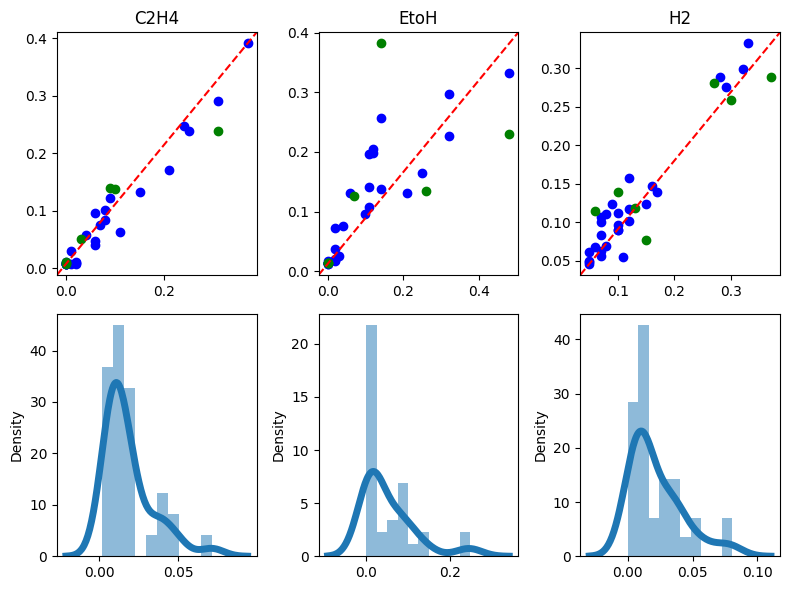

In [33]:
fig, ax = plt.subplots(2, 3, figsize=(8, 6))

# Scatter plot on row 0
row, col = 0, 0
ax[row, col].scatter(to_np(y_train[:, col]), to_np(output[:, col]), color='blue')
ax[row, col].scatter(to_np(y_test[:, col]), to_np(output_test[:, col]), color='green')
ax[row, col].plot([0, 1], [0, 1], transform=ax[0, col].transAxes, color='red', linestyle='--')
ax[row, col].set_title(target_column[col])

row, col = 0, 1
ax[row, col].scatter(to_np(y_train[:, col]), to_np(output[:, col]), color='blue')
ax[row, col].scatter(to_np(y_test[:, col]), to_np(output_test[:, col]), color='green')
ax[row, col].plot([0, 1], [0, 1], transform=ax[row, col].transAxes, color='red', linestyle='--')
ax[row, col].set_title(target_column[col])

row, col = 0, 2
ax[row, col].scatter(to_np(y_train[:, col]), to_np(output[:, col]), color='blue')
ax[row, col].scatter(to_np(y_test[:, col]), to_np(output_test[:, col]), color='green')
ax[row, col].plot([0, 1], [0, 1], transform=ax[row, col].transAxes, color='red', linestyle='--')
ax[row, col].set_title(target_column[col])


# KDE plot on row 1
row, col = 1, 0
y_data = np.concatenate([to_np(y_train[:, col]), to_np(y_test[:, col])])
output_data = np.concatenate([to_np(output[:, col]), to_np(output_test[:, col])])
error = np.abs(y_data - output_data)
_, _, hist1 = ax[row, col].hist(error, density=True, alpha=0.5)
sns.kdeplot(error, ax=ax[row, col], color=hist1.patches[0].get_facecolor(), lw=5)

row, col = 1, 1
y_data2 = np.concatenate([to_np(y_train[:, col]), to_np(y_test[:, col])])
output_data2 = np.concatenate([to_np(output[:, col]), to_np(output_test[:, col])])
error2 = np.abs(y_data2 - output_data2)
_, _, hist2 = ax[row, col].hist(error2, density=True, alpha=0.5)
sns.kdeplot(error2, ax=ax[row, col], color=hist2.patches[0].get_facecolor(), lw=5)

row, col = 1, 2
y_data3 = np.concatenate([to_np(y_train[:, col]), to_np(y_test[:, col])])
output_data3 = np.concatenate([to_np(output[:, col]), to_np(output_test[:, col])])
error3 = np.abs(y_data3 - output_data3)
_, _, hist3 = ax[row, col].hist(error3, density=True, alpha=0.5)
sns.kdeplot(error3, ax=ax[row, col], color=hist3.patches[0].get_facecolor(), lw=5)


plt.tight_layout()
plt.show()
sns.despine(fig=fig, offset=10)